In [1]:
import pandas as pd
import boto3
import os
import pandas as pd
from io import BytesIO
from dotenv import load_dotenv
from pycaret.regression import setup, compare_models, tune_model, pull, save_model

In [2]:
df_2023 = pd.read_csv('halfmarathon_wroclaw_2023__final.csv', sep=';')
df_2023.head()

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo
0,1.0,1787,TOMASZ,GRYCKO,NaN,POL,UKS BLIZA WŁADYSŁAWOWO,M,1.0,M30,...,2.926667,00:44:47,1.0,3.106667,01:01:43,1.0,3.386667,0.031400,01:04:59,3.080509
1,2.0,3,ARKADIUSZ,GARDZIELEWSKI,WROCŁAW,POL,ARKADIUSZGARDZIELEWSKI.PL,M,2.0,M30,...,2.983333,00:45:26,2.0,3.143333,01:03:08,2.0,3.540000,0.038000,01:06:23,3.146875
2,3.0,3832,KRZYSZTOF,HADAS,POZNAŃ,POL,NaN,M,3.0,M20,...,3.123333,00:47:34,3.0,3.236667,01:05:09,3.0,3.516667,0.024067,01:08:24,3.242475
3,4.0,416,DAMIAN,DYDUCH,KĘPNO,POL,AZS POLITECHNIKA OPOLSKA,M,4.0,M30,...,3.196667,00:48:49,5.0,3.330000,01:06:54,4.0,3.616667,0.025467,01:10:16,3.330963
4,5.0,8476,KAMIL,MAŃKOWSKI,MIRKÓW,POL,PARKRUN WROCŁAW,M,5.0,M20,...,3.276667,00:49:31,7.0,3.386667,01:07:27,5.0,3.586667,0.023000,01:10:27,3.339654


In [3]:
# funkcja, która zamienia całkowity czas biegu na sekundy
def convert_time_to_seconds(time):
    if pd.isnull(time) or time in ['DNS', 'DNF']:
        return None
    time = time.split(':')
    return int(time[0]) * 3600 + int(time[1]) * 60 + int(time[2])

In [4]:
# Korzystamy z funkcji dla danych z 2023
df_2023['Czas'] = df_2023['Czas'].apply(convert_time_to_seconds)

In [5]:
# Pokazujemy, że działa dla 5 pierwszych rekordów
df_2023['Czas'].head()

0    3899.0
1    3983.0
2    4104.0
3    4216.0
4    4227.0
Name: Czas, dtype: float64

In [6]:
# Wczytujemy dane z 2024, używamy funkcji konwertowania czasu na sekundy i sprawdzamy czy działa
df_2024 = pd.read_csv('halfmarathon_wroclaw_2024__final.csv', sep=';')
df_2024['Czas'] = df_2024['Czas'].apply(convert_time_to_seconds)
df_2024['Czas'].head()

0    3843.0
1    3864.0
2    3880.0
3    4184.0
4    4205.0
Name: Czas, dtype: float64

In [7]:
# Zapisujemy przekształcone dane do plików csv
df_2023.to_csv("dane_2023.csv")
df_2024.to_csv("dane_2024.csv")

## Przechodzimy więc do umieszczenia danych w Digital Ocean.

In [14]:
# ladujemy klucze
load_dotenv()
BUCKET_NAME='testbenderz'

# nawiazujemy kontakt z naszym wiadrem w Digital Ocean
s3 = boto3.client(
    "s3",
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    # Endpoint jest potrzebny dlatego że używamy chmury innej niż AWS 
    endpoint_url=os.getenv("AWS_ENDPOINT_URL_S3"), 
    # Gdybyśmy używali AWS to musielibyśmy natomiast podać region
    #region_name='eu-central-1'
)

try:
    s3.head_bucket(Bucket=BUCKET_NAME)
    print('Wszystko OK. Połączenie z bazą danych w Digital Ocean zostało nawiązane poprawnie i działa')
except Exception as e:
    print(f"Błąd połączenia z bazą danych w Digital Ocean z powodu: {str(e)}")

Wszystko OK. Połączenie z bazą danych w Digital Ocean zostało nawiązane poprawnie i działa


In [15]:
# wyszukiwanie plików zaczynających się od 'halfmarathon_'
current_directory = os.getcwd()
files_to_upload = [f for f in os.listdir(current_directory) if f.startswith("dane_")]

# wysylamy teraz pliki z danymi z polmaratonow do naszego Cloud Storage w Digital Ocean
for file_name in files_to_upload:
    file_path = os.path.join(current_directory, file_name)
    s3_path = file_name.replace("\\", "/")
    print(f"Wysyłam plik {file_path} do {s3_path}")
    s3.upload_file(
        Filename=file_path,
        Bucket=BUCKET_NAME,
        Key=s3_path
    )

Wysyłam plik c:\Users\Rafal\OneDrive\Pulpit\od_zera_do_ai\UCZENIE MASZYNOWE_PORA_TO_OGARNAC\dodaje do digital ocean — kopia\dane_2023.csv do dane_2023.csv
Wysyłam plik c:\Users\Rafal\OneDrive\Pulpit\od_zera_do_ai\UCZENIE MASZYNOWE_PORA_TO_OGARNAC\dodaje do digital ocean — kopia\dane_2024.csv do dane_2024.csv


In [16]:
# sprawdzamy, czy sie udalo i mamy tam pliki na Digital Ocean
response = s3.list_objects_v2(Bucket=BUCKET_NAME)

if "Contents" in response:
    print(f"Pliki w bucket {BUCKET_NAME}:")
    for obj in response.get("Contents", []):
        print(obj["Key"])
else:
    print(f"Brak plików w bucket {BUCKET_NAME}.")

Pliki w bucket testbenderz:
dane_2023.csv
dane_2024.csv


In [17]:
# wczytujemy nasze pliki z Digital Ocean w locie, bez zapisywania ich na dysk
response = s3.list_objects_v2(Bucket=BUCKET_NAME)

## Sprawdzamy, czy są jakieś pliki
if "Contents" in response and len(response["Contents"]) > 0:
    for i, obj in enumerate(response["Contents"]):
        file_key = obj["Key"]
        
        # Używamy BytesIO do pobrania pliku w locie
        obj_data = s3.get_object(Bucket=BUCKET_NAME, Key=file_key)
        data = obj_data['Body'].read()  # Pobieramy dane pliku
        
        # Wczytanie danych do DataFrame z użyciem separatora ';'
        df = pd.read_csv(BytesIO(data), sep=';')

        # Nazwa DataFrame na podstawie roku
        year = 2023 + i
        globals()[f'bieg_{year}_df'] = df
        
        print(f"Wczytano plik z bucketu: {BUCKET_NAME} o nazwie: {file_key}. Utworzono DataFrame: bieg_{year}_df.")
else:
    print(f"Brak dostępnych plików w buckecie {BUCKET_NAME}.")

Wczytano plik z bucketu: testbenderz o nazwie: dane_2023.csv. Utworzono DataFrame: bieg_2023_df.
Wczytano plik z bucketu: testbenderz o nazwie: dane_2024.csv. Utworzono DataFrame: bieg_2024_df.


In [18]:
# Zamieniamy Rocznik zawodnika na ich wiek poprzez genialną metodą odejmowania :)
df_2023['Wiek'] = 2023 - df_2023['Rocznik']
df_2024['Wiek'] = 2024 - df_2024['Rocznik']

In [19]:
# Łączymy obydwa pliki z danymi
df_full = pd.concat([df_2023, df_2024], ignore_index=True)

In [20]:
df_full.isna().sum() / len(df_full) * 100

Miejsce                      15.972127
Numer startowy                0.000000
Imię                          0.000000
Nazwisko                      0.000000
Miasto                       19.050872
Kraj                         15.972127
Drużyna                      61.734299
Płeć                          0.050098
Płeć Miejsce                 15.972127
Kategoria wiekowa             0.141185
Kategoria wiekowa Miejsce    16.063214
Rocznik                       2.208863
5 km Czas                    16.149747
5 km Miejsce Open            16.149747
5 km Tempo                   16.149747
10 km Czas                   16.076878
10 km Miejsce Open           16.076878
10 km Tempo                  16.222617
15 km Czas                   16.072323
15 km Miejsce Open           16.072323
15 km Tempo                  16.140639
20 km Czas                   16.022225
20 km Miejsce Open           16.022225
20 km Tempo                  16.099649
Tempo Stabilność             16.304595
Czas                     

In [21]:
# Tworzymy tylko taki dataframe dla których będziemy trenować model, wg założenia: płeć, czas, wiek, tempo na 5km
df = df_full[["Płeć", "5 km Tempo", "Czas", "Wiek"]]

In [22]:
# Sprawdzamy procentowo brakujace dane
df.isna().sum() / len(df) * 100

Płeć           0.050098
5 km Tempo    16.149747
Czas          15.972127
Wiek           2.208863
dtype: float64

In [23]:
# Usuwamy brakujące wartości
df = df.dropna()

In [24]:
exp = setup(data = df, target="Czas", session_id=33)

,Description,Value
0,Session id,33
1,Target,Czas
2,Target type,Regression
3,Original data shape,"(17927, 4)"
4,Transformed data shape,"(17927, 4)"
5,Transformed train set shape,"(12548, 4)"
6,Transformed test set shape,"(5379, 4)"
7,Numeric features,2
8,Categorical features,1
9,Preprocess,True


In [25]:
best_model = compare_models()

Processing:   0%|          | 0/77 [00:00<?, ?it/s]

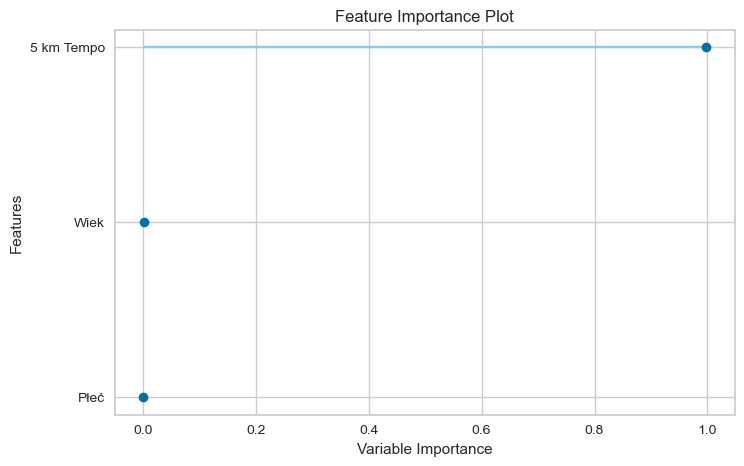

In [16]:
exp.plot_model(best_model, plot='feature')

In [26]:
# Walczymy z outliersami, czyli wyrzucamy wartości odstające - jednostki wybitne i mniej wybitne
df_copy = df.copy()

In [27]:
Q1 = df_copy["Czas"].quantile(0.25)
Q3 = df_copy["Czas"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [28]:
no_outliers_df = df_copy[~((df_copy["Czas"] < lower_bound) | (df_copy["Czas"] > upper_bound))]

In [29]:
no_outliers_exp = setup(data = no_outliers_df, target="Czas", session_id=33)

,Description,Value
0,Session id,33
1,Target,Czas
2,Target type,Regression
3,Original data shape,"(17687, 4)"
4,Transformed data shape,"(17687, 4)"
5,Transformed train set shape,"(12380, 4)"
6,Transformed test set shape,"(5307, 4)"
7,Numeric features,2
8,Categorical features,1
9,Preprocess,True


In [30]:
no_outliers_best_model = no_outliers_exp.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,291.7934,158388.4911,397.8359,0.8795,0.0512,0.0385,0.2880
lightgbm,Light Gradient Boosting Machine,294.6988,161569.4508,401.8115,0.8771,0.0517,0.0389,16.3480
lasso,Lasso Regression,293.8752,165113.0997,405.9314,0.8743,0.0570,0.0387,0.0600
ridge,Ridge Regression,293.8647,165111.3285,405.9275,0.8743,0.0568,0.0387,0.0620
lar,Least Angle Regression,293.8589,165111.3078,405.9273,0.8743,0.0568,0.0387,0.0560
llar,Lasso Least Angle Regression,293.8752,165113.1101,405.9314,0.8743,0.0570,0.0387,0.0590
br,Bayesian Ridge,293.8604,165111.3263,405.9274,0.8743,0.0568,0.0387,0.0720
lr,Linear Regression,293.8589,165111.3078,405.9273,0.8743,0.0568,0.0387,0.0640
huber,Huber Regressor,289.3237,167484.7215,408.8489,0.8725,0.0573,0.0378,0.0980
rf,Random Forest Regressor,330.0954,200211.9845,447.3223,0.8477,0.0577,0.0437,0.7100


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

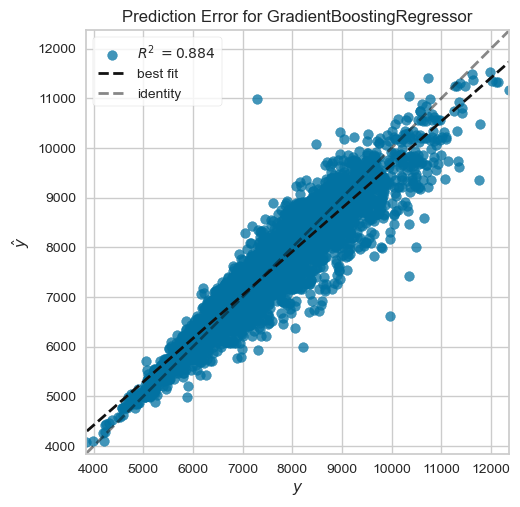

In [31]:
exp.plot_model(best_model, plot='error')

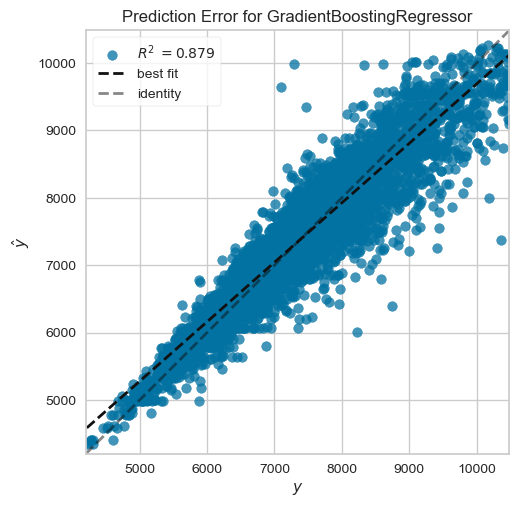

In [32]:
no_outliers_exp.plot_model(no_outliers_best_model, plot='error')

In [33]:
# Robimy optymalizację hiperparametrów - tuning

tuned_gbr_model = exp.tune_model(best_model, n_iter=50, optimize='R2')
results1 = pull()

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [34]:
# Optymalizacja dla no_outliers

tuned_no_outliers_gbr_model = exp.tune_model(no_outliers_best_model, n_iter=50, optimize='R2')
results2 = pull()


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [35]:
goat_model = exp.compare_models([best_model, no_outliers_best_model, tuned_gbr_model, tuned_no_outliers_gbr_model])

Processing:   0%|          | 0/21 [00:00<?, ?it/s]

In [36]:
exp.predict_model(best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,298.4866,170088.0955,412.4174,0.8844,0.0521,0.0390


,Płeć,5 km Tempo,Wiek,Czas,prediction_label
4984,K,5.896667,45.0,7538.0,7806.263196
11932,M,5.500000,19.0,6738.0,7275.997903
10939,M,4.746666,39.0,6400.0,6250.075462
12960,M,5.020000,53.0,7025.0,6547.101718
14791,K,5.840000,25.0,7540.0,7752.186445
...,...,...,...,...,...
17027,K,5.923333,57.0,8364.0,7898.283993
7028,K,6.183333,46.0,8743.0,8207.944846
9459,M,4.343333,40.0,5631.0,5751.999886
19056,M,5.626667,30.0,10359.0,7415.670065


In [37]:
exp.predict_model(no_outliers_best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,299.4452,172810.9710,415.7054,0.8825,0.0520,0.0389


,Płeć,5 km Tempo,Wiek,Czas,prediction_label
4984,K,5.896667,45.0,7538.0,7825.197816
11932,M,5.500000,19.0,6738.0,7282.937960
10939,M,4.746666,39.0,6400.0,6238.407616
12960,M,5.020000,53.0,7025.0,6564.331045
14791,K,5.840000,25.0,7540.0,7706.807423
...,...,...,...,...,...
17027,K,5.923333,57.0,8364.0,7899.148114
7028,K,6.183333,46.0,8743.0,8271.349923
9459,M,4.343333,40.0,5631.0,5757.363421
19056,M,5.626667,30.0,10359.0,7381.960879


In [38]:
exp.predict_model(goat_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,298.4866,170088.0955,412.4174,0.8844,0.0521,0.0390


,Płeć,5 km Tempo,Wiek,Czas,prediction_label
4984,K,5.896667,45.0,7538.0,7806.263196
11932,M,5.500000,19.0,6738.0,7275.997903
10939,M,4.746666,39.0,6400.0,6250.075462
12960,M,5.020000,53.0,7025.0,6547.101718
14791,K,5.840000,25.0,7540.0,7752.186445
...,...,...,...,...,...
17027,K,5.923333,57.0,8364.0,7898.283993
7028,K,6.183333,46.0,8743.0,8207.944846
9459,M,4.343333,40.0,5631.0,5751.999886
19056,M,5.626667,30.0,10359.0,7415.670065


In [39]:
best_final_model = exp.finalize_model(goat_model)
best_final_model

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['5 km Tempo', 'Wiek'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['Płeć'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('ordinal_encoding',
                 TransformerWrapper(include=['Płeć'],
                                    transformer=OrdinalEncoder(cols=['Płeć'],
                                                               handle_missing='return_nan',
                                                               mapping=[{'col': 'Płeć',
                                                                         'data_type': dtype('O'),
                                                                         'mapping': K      0
M      1
NaN   -1
dtype: int64}]))),
                ('clean_column_names',
                 TransformerWrapper(transformer=CleanColumnNames())),
                ('actual_estimator',
                 GradientBoostingRegressor(random_state=33))])

In [40]:
exp.save_model(best_final_model, "best_model", verbose=False);